In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

In [31]:
SSC_struct_rank_fil = "dat/bias/asd.asc.zmatch.rank.csv"
SSC_struct_rank_fil = "dat/bias/asc.norm.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_zmatch_graph_size, ssc_zmatch_stats, ssc_graphs = CircuitTrimming(g2, g)

In [32]:
SSC_struct_rank_fil = "dat/bias/asc.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_elevel_graph_size, ssc_elevel_stats, ssc_graphs = CircuitTrimming(g2, g)

In [2]:
SSC_struct_rank_fil = "dat/bias/asd.sparktada.zmatch.rank.csv"
SSC_struct_rank_fil = "dat/bias/sparktada.norm.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_zmatch_graph_size, tada_zmatch_stats, tada_graphs = CircuitTrimming(g2, g)

In [30]:
struct_rank_fil = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv"
g, top_structs = LoadConnectome(struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_graph_size, asc_exp_stats, asc_exp_graphs = CircuitTrimming(g2, g)

idx = np.argmax(asc_exp_stats)
print(50-idx)
STRS = [v["label"] for v in asc_exp_graphs[idx].vs]
RegionDistributionsList(STRS)

48
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Field_CA3; Dentate_gyrus
Midbrain 	 1 	 Anterior_pretectal_nucleus
Hippocampal_formation 	 4 	 Entorhinal_area_lateral_part; Parasubiculum; Subiculum_dorsal_part; Subiculum_ventral_part
Olfactory_areas 	 5 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_amygdalar_area; Piriform_area; Taenia_tecta
Striatum 	 2 	 Nucleus_accumbens; Caudoputamen
Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part
Isocortex 	 25 	 Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_posterior_part; Frontal_pole_cerebral_cortex; Infralimbic_area; Primary_motor_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Retrosplenial_area_dorsal_part; Primary_somatosensory_area_lower_limb; Primary_somatosensory_area_trunk; Supplemental_

In [7]:
struct_rank_fil = "dat/bias/asc.avgZ.weighted.MutNGL.bias.csv"
g, top_structs = LoadConnectome(struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_avgz_graph_size, asc_avgz_stats, asc_avgz_graphs = CircuitTrimming(g2, g)

idx = np.argmax(asc_avgz_stats)
print(50-idx)
STRS = [v["label"] for v in asc_avgz_graphs[idx].vs]
RegionDistributionsList(STRS)

7
Hippocampal_formation 	 1 	 Subiculum_dorsal_part
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Field_CA3; Dentate_gyrus
Striatum 	 1 	 Lateral_septal_nucleus_caudal_caudodorsal_part


In [8]:
struct_rank_fil = "dat/bias/spark.avgZ.weighted.MutNGL.bias.csv"
g, top_structs = LoadConnectome(struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
spark_graph_size, spark_exp_stats, spark_exp_graphs = CircuitTrimming(g2, g)

idx = np.argmax(spark_exp_stats)
print(50-idx)
STRS = [v["label"] for v in spark_exp_graphs[idx].vs]
RegionDistributionsList(STRS)

41
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure
Hippocampal_formation 	 1 	 Subiculum_dorsal_part
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Field_CA3; Dentate_gyrus
Cortical_subplate 	 3 	 Basolateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part
Isocortex 	 22 	 Anterior_cingulate_area_dorsal_part; Agranular_insular_area_dorsal_part; Agranular_insular_area_ventral_part; Dorsal_auditory_area; Gustatory_areas; Primary_motor_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_lower_limb; Primary_somatosensory_area_mouth; Primary_somatosensory_area_trunk; Primary_somatosensory_area_upper_limb; Anterolateral_visual_area; Ante

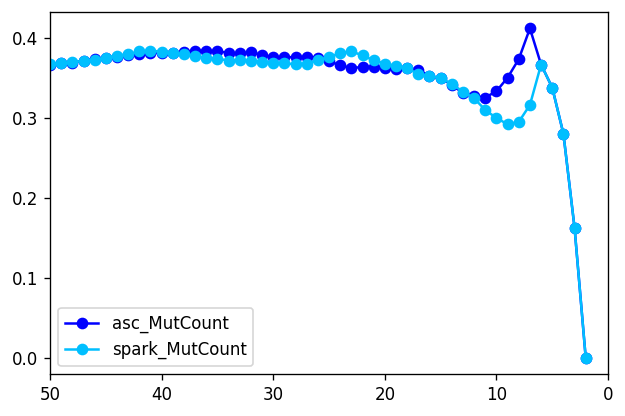

In [9]:
fig, ax = plt.subplots(dpi=120)
ax.plot(asc_avgz_graph_size, asc_avgz_stats, marker="o", color="blue", label="asc_MutCount")
ax.plot(spark_graph_size, spark_exp_stats, marker="o", color="deepskyblue", label="spark_MutCount")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()

In [34]:
SSC_struct_rank_fil = "dat/bias/sparktada.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
tada_elevel_graph_size, tada_elevel_stats, tada_graphs = CircuitTrimming(g2, g)

In [35]:
SSC_struct_rank_fil = "dat/bias/asd.sib.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_zmatch_graph_size, sib_zmatch_stats, sib_graphs = CircuitTrimming(g2, g)

In [36]:
SSC_struct_rank_fil = "dat/bias/sib.explevel.rank.tsv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_elevel_graph_size, sib_elevel_stats, sib_graphs = CircuitTrimming(g2, g)

In [37]:
rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=rand_strs)
g2 = g.subgraph(top_nodes)
rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)

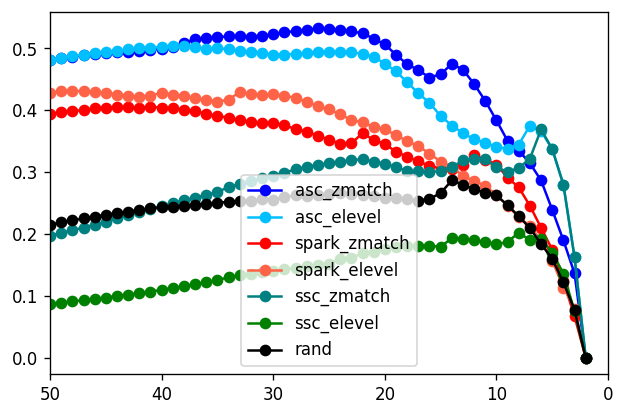

In [38]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="asc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="asc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="spark_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="spark_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()

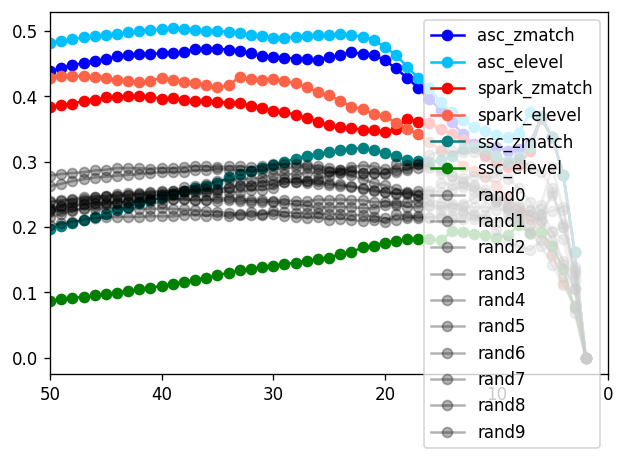

In [28]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ssc_zmatch_graph_size, ssc_zmatch_stats, marker="o", color="blue", label="asc_zmatch")
ax.plot(ssc_elevel_graph_size, ssc_elevel_stats, marker="o", color="deepskyblue", label="asc_elevel")
ax.plot(tada_zmatch_graph_size, tada_zmatch_stats, marker="o", color="red", label="spark_zmatch")
ax.plot(tada_elevel_graph_size, tada_elevel_stats, marker="o", color="tomato", label="spark_elevel")
ax.plot(sib_zmatch_graph_size, sib_zmatch_stats, marker="o", color="teal", label="ssc_zmatch")
ax.plot(sib_elevel_graph_size, sib_elevel_stats, marker="o", color="green", label="ssc_elevel")
for i in range(10):
    rand_strs = pd.read_csv("dat/bias/sib.explevel.rank.tsv").sample(frac = 1).head(50)["STR"].values
    g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
    top_nodes = g.vs.select(label_in=rand_strs)
    g2 = g.subgraph(top_nodes)
    rand_graph_size, rand_stats, rand_graphs = CircuitTrimming(g2, g)
    ax.plot(rand_graph_size, rand_stats, marker="o", color="black", label="rand%d"%i, alpha=0.3)
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()

In [1]:
## Compare SSC_ALL M/F MH/HL

In [12]:
ssc_all = "dat/bias/ssc.allmut.csv"
g, top_structs = LoadConnectome(ssc_all, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_all_graph_size, ssc_all_stats, ssc_all_graphs = CircuitTrimming(g2, g)

ssc_male = "dat/bias/ssc.M.allmut.csv"
g, top_structs = LoadConnectome(ssc_male, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_male_graph_size, ssc_male_stats, ssc_male_graphs = CircuitTrimming(g2, g)

ssc_female = "dat/bias/ssc.F.allmut.csv"
g, top_structs = LoadConnectome(ssc_female, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_female_graph_size, ssc_female_stats, ssc_female_graphs = CircuitTrimming(g2, g)

ssc_low = "dat/bias/ssc.L.allmut.csv"
g, top_structs = LoadConnectome(ssc_low, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_low_graph_size, ssc_low_stats, ssc_low_graphs = CircuitTrimming(g2, g)

ssc_high = "dat/bias/ssc.H.allmut.csv"
g, top_structs = LoadConnectome(ssc_high, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
ssc_high_graph_size, ssc_high_stats, ssc_high_graphs = CircuitTrimming(g2, g)

sib_all = "dat/bias/sib.allmut.csv"
g, top_structs = LoadConnectome(sib_all, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_all_graph_size, sib_all_stats, sib_all_graphs = CircuitTrimming(g2, g)

sib_all2 = "dat/bias/sib.allmut.NoWeight.csv"
g, top_structs = LoadConnectome(sib_all2, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
sib_all2_graph_size, ssib_all2_stats, sib_all2_graphs = CircuitTrimming(g2, g)

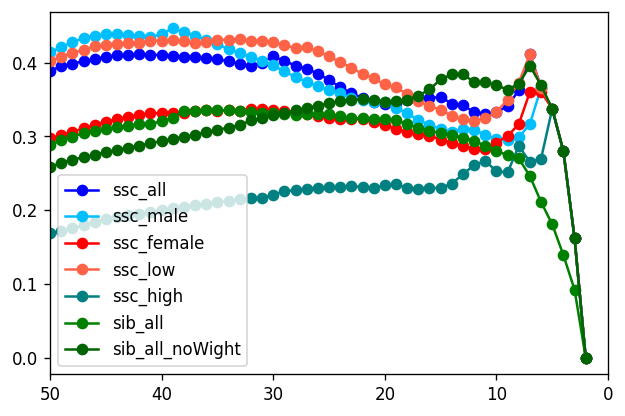

In [13]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ssc_all_graph_size, ssc_all_stats, marker="o", color="blue", label="ssc_all")
ax.plot(ssc_male_graph_size, ssc_male_stats, marker="o", color="deepskyblue", label="ssc_male")
ax.plot(ssc_female_graph_size, ssc_female_stats, marker="o", color="red", label="ssc_female")
ax.plot(ssc_low_graph_size, ssc_low_stats, marker="o", color="tomato", label="ssc_low")
ax.plot(ssc_high_graph_size, ssc_high_stats, marker="o", color="teal", label="ssc_high")
ax.plot(sib_all_graph_size, sib_all_stats, marker="o", color="green", label="sib_all")
ax.plot(sib_all2_graph_size, ssib_all2_stats, marker="o", color="darkgreen", label="sib_all_noWight")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()

In [15]:
asc_RR = "dat/bias/asc.explevel.weighted.RR.bias.csv"
g, top_structs = LoadConnectome(asc_RR, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_RR_graph_size, asc_RR_stats, asc_RR_graphs = CircuitTrimming(g2, g)

asc_MutCount = "dat/bias/asc.explevel.weighted.Mutcount.bias.csv"
g, top_structs = LoadConnectome(asc_MutCount, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_MutCount_graph_size, asc_MutCount_stats, asc_MutCount_graphs = CircuitTrimming(g2, g)

asc_lofZ = "dat/bias/asc.explevel.weighted.LofZ.bias.csv"
g, top_structs = LoadConnectome(asc_lofZ, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_lofZ_graph_size, asc_lofZ_stats, asc_lofZ_graphs = CircuitTrimming(g2, g)

asc_uniform = "dat/bias/asc.explevel.weighted.Uniform.bias.csv"
g, top_structs = LoadConnectome(asc_uniform, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_uniform_graph_size, asc_uniform_stats, asc_uniform_graphs = CircuitTrimming(g2, g)

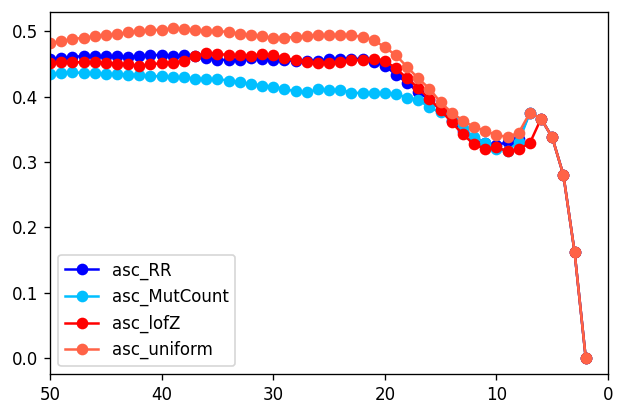

In [16]:
fig, ax = plt.subplots(dpi=120)
ax.plot(asc_RR_graph_size, asc_RR_stats, marker="o", color="blue", label="asc_RR")
ax.plot(asc_MutCount_graph_size, asc_MutCount_stats, marker="o", color="deepskyblue", label="asc_MutCount")
ax.plot(asc_lofZ_graph_size, asc_lofZ_stats, marker="o", color="red", label="asc_lofZ")
ax.plot(asc_uniform_graph_size, asc_uniform_stats, marker="o", color="tomato", label="asc_uniform")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()

In [20]:
asc_RR = "dat/bias/sparktada.explevel.weighted.RR.bias.csv"
g, top_structs = LoadConnectome(asc_RR, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_RR_graph_size, asc_RR_stats, asc_RR_graphs = CircuitTrimming(g2, g)

asc_MutCount = "dat/bias/sparktada.explevel.weighted.Mutcount.bias.csv"
g, top_structs = LoadConnectome(asc_MutCount, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_MutCount_graph_size, asc_MutCount_stats, asc_MutCount_graphs = CircuitTrimming(g2, g)

asc_lofZ = "dat/bias/sparktada.explevel.weighted.LofZ.bias.csv"
g, top_structs = LoadConnectome(asc_lofZ, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_lofZ_graph_size, asc_lofZ_stats, asc_lofZ_graphs = CircuitTrimming(g2, g)

asc_uniform = "dat/bias/sparktada.explevel.weighted.Uniform.bias.csv"
g, top_structs = LoadConnectome(asc_uniform, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)
asc_uniform_graph_size, asc_uniform_stats, asc_uniform_graphs = CircuitTrimming(g2, g)

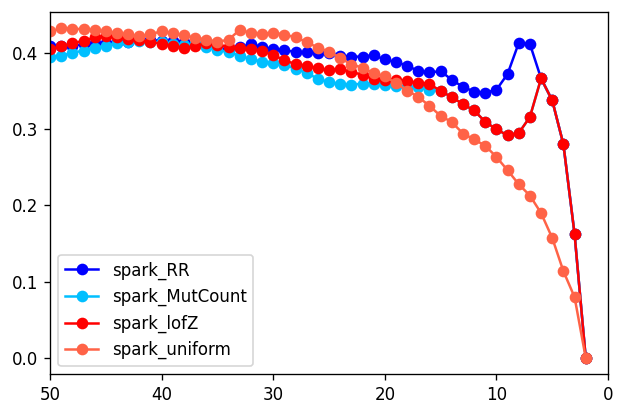

In [22]:
fig, ax = plt.subplots(dpi=120)
ax.plot(asc_RR_graph_size, asc_RR_stats, marker="o", color="blue", label="spark_RR")
ax.plot(asc_MutCount_graph_size, asc_MutCount_stats, marker="o", color="deepskyblue", label="spark_MutCount")
ax.plot(asc_lofZ_graph_size, asc_lofZ_stats, marker="o", color="red", label="spark_lofZ")
ax.plot(asc_uniform_graph_size, asc_uniform_stats, marker="o", color="tomato", label="spark_uniform")
ax.set_xlim(50, 0)  # decreasing time
plt.legend()
plt.show()